In [99]:
import sys
sys.path.append('..')
import pandas as pd
import numpy as np
import os
import json
from pathlib import Path
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from utils import model_utils, file_utils
from utils.callbacks import EvalCallback

from finrl.meta.env_stock_trading.env_stocktrading import StockTradingEnv
from finrl.meta.preprocessor.preprocessors import data_split
from stable_baselines3.common.vec_env import DummyVecEnv, VecMonitor, VecNormalize

from finrl.plot import backtest_stats

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [116]:
HYPERPARAMETERS_PATH = '..\TUNING\PETR4\DDPG_200_17_18_FUND_SORTINO'

In [117]:
env_kwargs = json.load(open(os.path.join(HYPERPARAMETERS_PATH, 'env_train_kwargs.json'), 'r'))
args = json.load(open(os.path.join(HYPERPARAMETERS_PATH, 'command_line_args.json'), 'r'))
print('ENV KWARGS')
print(env_kwargs, '\n')
print('ARGS')
print(args)

TEST_PATH = file_utils.uniquify(os.path.join('TESTS', '_'.join(args['tickers']), args['alg']))
os.makedirs(TEST_PATH, exist_ok=True)
os.makedirs(os.path.join(TEST_PATH, 'monitor_logs'), exist_ok=True)
os.makedirs(os.path.join(TEST_PATH, 'tb_log'), exist_ok=True)

ENV KWARGS
{'stock_dim': 1, 'hmax': 200, 'initial_amount': 100000, 'num_stock_shares': [0], 'buy_cost_pct': [0.001], 'sell_cost_pct': [0.001], 'reward_scaling': 1, 'state_space': 15, 'action_space': 1, 'tech_indicator_list': ['LPA', 'VPA', 'P/L', 'P/EBITDA', 'P/VPA', 'DL/PL', 'DL/EBITDA', 'ROE', 'MARGEM_EBITDA', 'DL/EBIT', 'MARGEM_EBIT', 'MARGEM_LIQUIDA'], 'turbulence_threshold': None, 'print_verbosity': 1000} 

ARGS
{'alg': 'DDPG', 'tickers': ['PETR4.SA'], 'tuning_timesteps': 20000, 'train_timesteps': 200000, 'train_period': ['2017-01-01', '2018-12-31'], 'eval_period': ['2019-01-01', '2019-12-31'], 'trade_period': ['2020-01-01', '2021-12-31'], 'hmax': 200, 'use_ohlcv': False, 'initial_amount': 100000, 'n_trials': 100, 'n_repeats_by_trial': 5, 'output_path': 'DDPG_200_17_18_FUND_SORTINO', 'metric_to_optimize': 'Sortino ratio', 'n_eval_episodes': 1, 'use_best_model': True, 'use_fundamental_indicators': True, 'use_tech_indicators': False, 'indicators': ['macd', 'boll_ub', 'boll_lb', 'rsi

In [118]:
df_hyperparameters = pd.read_csv(os.path.join(HYPERPARAMETERS_PATH, 'hp_tuning_hist.csv'))
df_hyperparameters_group = df_hyperparameters.groupby(['trial', 'hyperparameters']).agg(['mean', 'std']).reset_index()
df_hyperparameters_group = df_hyperparameters_group.sort_values(('metric', 'mean'), ascending=False)

display(df_hyperparameters_group.head())

print('Best Trial: {} | Mean Metric: {:.4f} +- {:.4f}'.format(
    df_hyperparameters_group.iloc[0]['trial'][0], 
    df_hyperparameters_group.iloc[0][('metric', 'mean')],
    df_hyperparameters_group.iloc[0][('metric', 'std')],
    
    )
)

best_params = eval(df_hyperparameters_group.iloc[0]['hyperparameters'][0])
best_params = model_utils.load_params_from_store_format(best_params)

best_params

trial                                    hyperparameters    metric  \
                                                                 mean   
14    14  {'gamma': 0.999, 'learning_starts': 2000, 'lea...  0.253123   
1      1  {'gamma': 0.999, 'learning_starts': 2000, 'lea...  0.250237   
4      4  {'gamma': 0.999, 'learning_starts': 2000, 'lea...  0.249858   
12    12  {'gamma': 0.999, 'learning_starts': 2000, 'lea...  0.241038   
3      3  {'gamma': 0.999, 'learning_starts': 2000, 'lea...  0.238891   

              
         std  
14  0.002769  
1   0.047348  
4   0.036527  
12  0.042218  
3   0.012884

Best Trial: 14 | Mean Metric: 0.2531 +- 0.0028


{'gamma': 0.999,
 'learning_starts': 2000,
 'learning_rate': 5.1878120697949025e-05,
 'batch_size': 512,
 'buffer_size': 10000,
 'train_freq': (8, 'step')}

In [119]:
df = pd.read_pickle(os.path.join(HYPERPARAMETERS_PATH, 'dataset.pkl'))

train_set = data_split(df, args['train_period'][0], args['eval_period'][1])
eval_set = data_split(df, args['eval_period'][0], args['eval_period'][1])
trade_set = data_split(df, args['trade_period'][0], args['trade_period'][1])
# trade_set = data_split(df, '2021-01-01', '2021-12-31')

trade_set['date'] = pd.to_datetime(trade_set['date'])

print('Train\t', train_set['close'].iloc[-1] / train_set['close'].iloc[0] - 1)
print('Eval\t', eval_set['close'].iloc[-1] / eval_set['close'].iloc[0] - 1)
print('Trade\t', trade_set['close'].iloc[-1] / trade_set['close'].iloc[0] - 1)

Train	 1.098681634563044
Eval	 0.2960293754293346
Trade	 0.14384809817977207


USANDO BEST MODEL
TIMESTEPS: 12610


,Model,Buy and Hold
Annual return,0.078905,0.072482
Cumulative returns,0.157041,0.143848
Annual volatility,0.534023,0.580281
Sharpe ratio,0.421226,0.424109
Calmar ratio,0.125167,0.114405
Stability,0.407223,0.398792
Max drawdown,-0.630396,-0.633561
Omega ratio,1.096216,1.089995
Sortino ratio,0.565378,0.567288
Skew,NaN,NaN


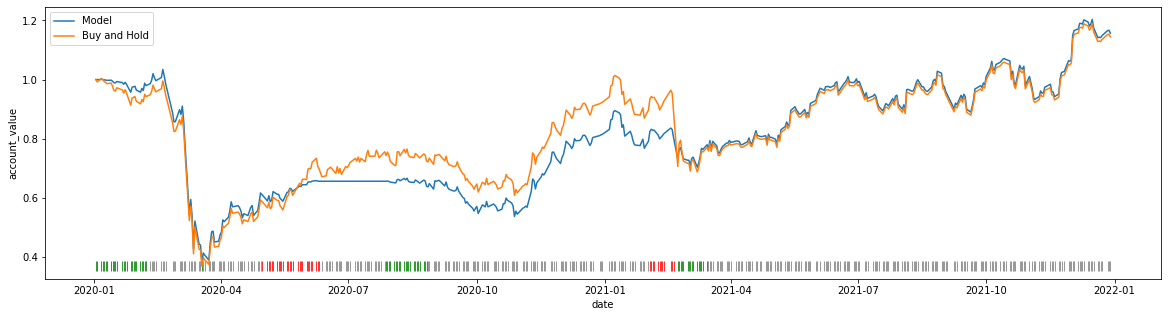

USANDO BEST MODEL
TIMESTEPS: 4365


,Model,Buy and Hold
Annual return,0.093901,0.072482
Cumulative returns,0.188125,0.143848
Annual volatility,0.511960,0.580281
Sharpe ratio,0.443643,0.424109
Calmar ratio,0.148949,0.114405
Stability,0.438986,0.398792
Max drawdown,-0.630421,-0.633561
Omega ratio,1.112101,1.089995
Sortino ratio,0.596101,0.567288
Skew,NaN,NaN


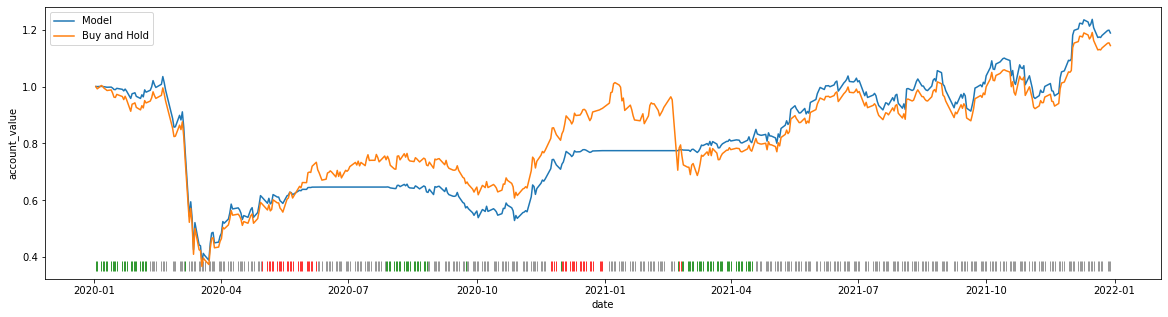

USANDO BEST MODEL
TIMESTEPS: 1455


,Model,Buy and Hold
Annual return,0.126562,0.072482
Cumulative returns,0.257194,0.143848
Annual volatility,0.553506,0.580281
Sharpe ratio,0.503269,0.424109
Calmar ratio,0.214108,0.114405
Stability,0.448762,0.398792
Max drawdown,-0.591110,-0.633561
Omega ratio,1.108072,1.089995
Sortino ratio,0.678577,0.567288
Skew,NaN,NaN


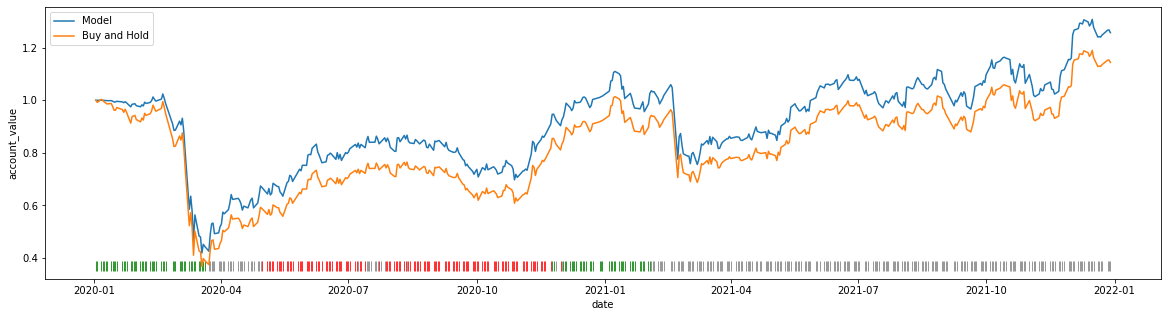

In [120]:
a = 14

MODEL_TYPE = 'best' # *'best' or 'final'

for b in range(0, 10):
    try:
        dataset = trade_set.copy() #data_split(trade_set, '2020-01-01', '2021-12-31').copy()
        dataset['date'] = pd.to_datetime(dataset['date'])

        e_eval_gym = StockTradingEnv(df=dataset, **env_kwargs)
        env_eval = DummyVecEnv([lambda: e_eval_gym])

        env_statistics_path = os.path.join(
            HYPERPARAMETERS_PATH, 
            'models',
            'TRIAL_{}_REPEAT_{}'.format(a, b),
            f'env_statistics_{MODEL_TYPE}'
        )

        env_eval = VecNormalize.load(
            env_statistics_path,
            env_eval,
        )
        env_eval.training = False
        env_eval.norm_reward = False

        best_model_path = os.path.join(
            HYPERPARAMETERS_PATH, 
            f'models',
            'TRIAL_{}_REPEAT_{}'.format(a, b),
            f'model_{MODEL_TYPE}.zip'
        )

        MODEL = model_utils.get_model(args['alg'])
        trained_model = MODEL.load(best_model_path, env_eval)

        print('USANDO BEST MODEL')
        print('TIMESTEPS:', trained_model.num_timesteps)


        account_memory, actions_memory, state_memory = model_utils.predict(
            trained_model, 
            env_eval, 
            True
        )

        account_temp = pd.DataFrame({
            'date': account_memory['date'],
            'account_value': dataset['close']
        })

        display(
            pd.concat([
                backtest_stats(account_value=account_memory),
                backtest_stats(account_value=account_temp)
            ], axis=1).rename(columns={0: 'Model', 1: 'Buy and Hold'})
        )

        cum_return_model = (account_memory['account_value'].pct_change(1)+1).cumprod().fillna(1)
        cum_return_beh = (dataset['close'].pct_change(1)+1).cumprod().fillna(1)

        actions_plot = np.where(
            actions_memory['actions'] > 0, 
            'green', 
            np.where(actions_memory['actions'] < 0,
                'red',
                'gray'
            )
        ).tolist() + ['gray']

        %matplotlib inline
        plt.figure(figsize=(20,5))
        sns.lineplot(x=dataset['date'], y=cum_return_model, label='Model')
        sns.lineplot(x=dataset['date'], y=cum_return_beh, label='Buy and Hold')

        sns.scatterplot(x=dataset['date'], y=min(cum_return_model.min(), cum_return_beh.min()), c=actions_plot, marker='|', s=100)
        plt.show()

    except Exception as e:
        break

## Retreino

In [124]:
e_train_gym = StockTradingEnv(
    df=train_set, 
    **env_kwargs
)
env_train = DummyVecEnv([lambda: e_train_gym])
env_train = VecMonitor(
    env_train, 
    os.path.join('.')
)

env_train = VecNormalize(
    env_train, 
    training=True,
    norm_obs=True, 
    norm_reward=True,
    gamma=best_params['gamma']
)
MODEL = model_utils.get_model(args['alg'])
model = MODEL(
    policy='MlpPolicy', 
    env=env_train,
    **best_params,
    verbose=True,
    seed=None,
    tensorboard_log=os.path.join('.')
)

eval_callback = EvalCallback(
    env_train, 
    n_eval_episodes=1,
    eval_freq=int(train_set.shape[0]/len(args['tickers'])),
    best_model_save_path=os.path.join('.'),
    verbose=False
)
trained_model = model.learn(
    tb_log_name='retreino',
    log_interval=1,
    total_timesteps=train_set.shape[0] * 20,
    callback=[eval_callback],
    reset_num_timesteps=True
)

Using cuda device
Logging to .\retreino_2
---------------------------------
| eval/              |          |
|    mean_reward     | 1.07e+05 |
| time/              |          |
|    total_timesteps | 727      |
---------------------------------
----------------------------------
| rollout/           |           |
|    ep_len_mean     | 727       |
|    ep_rew_mean     | 13588.208 |
| time/              |           |
|    episodes        | 1         |
|    fps             | 365       |
|    time_elapsed    | 1         |
|    total_timesteps | 727       |
----------------------------------
---------------------------------
| eval/              |          |
|    mean_reward     | 7.26e+04 |
| time/              |          |
|    total_timesteps | 1454     |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 727      |
|    ep_rew_mean     | 17261.89 |
| time/              |          |
|    episodes        | 2      

USANDO BEST MODEL
TIMESTEPS: 13813


,Model,Buy and Hold
Annual return,0.194256,0.072482
Cumulative returns,0.406293,0.143848
Annual volatility,0.489138,0.580281
Sharpe ratio,0.615097,0.424109
Calmar ratio,0.343849,0.114405
Stability,0.610279,0.398792
Max drawdown,-0.564944,-0.633561
Omega ratio,1.152270,1.089995
Sortino ratio,0.855478,0.567288
Skew,NaN,NaN


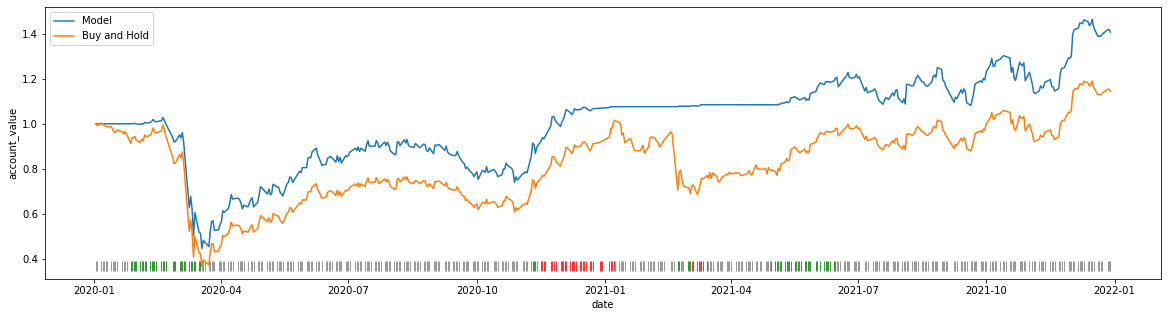

In [125]:
dataset = trade_set.copy()

e_eval_gym = StockTradingEnv(df=dataset, **env_kwargs)
env_eval = DummyVecEnv([lambda: e_eval_gym])
env_eval = VecNormalize.load(os.path.join('.', 'env_statistics_best'), env_eval)

env_eval.training = False
env_eval.norm_reward = False

MODEL = model_utils.get_model(args['alg'])
best_model = MODEL.load(os.path.join('.', 'model_best.zip'), env_eval)

print('USANDO BEST MODEL')
print('TIMESTEPS:', best_model.num_timesteps)

account_memory, actions_memory, state_memory = model_utils.predict(
    best_model, 
    env_eval, 
    True
)

account_temp = pd.DataFrame({
    'date': account_memory['date'],
    'account_value': dataset['close']
})

display(
    pd.concat([
        backtest_stats(account_value=account_memory),
        backtest_stats(account_value=account_temp)
    ], axis=1).rename(columns={0: 'Model', 1: 'Buy and Hold'})
)

cum_return_model = (account_memory['account_value'].pct_change(1)+1).cumprod().fillna(1)
cum_return_beh = (dataset['close'].pct_change(1)+1).cumprod().fillna(1)

actions_plot = np.where(
    actions_memory['actions'] > 0, 
    'green', 
    np.where(
        actions_memory['actions'] < 0,
        'red',
        'gray'
    )
).tolist() + ['gray']

%matplotlib inline
plt.figure(figsize=(20,5))
sns.lineplot(x=dataset['date'], y=cum_return_model, label='Model')
sns.lineplot(x=dataset['date'], y=cum_return_beh, label='Buy and Hold')

sns.scatterplot(x=dataset['date'], y=min(cum_return_model.min(), cum_return_beh.min()), c=actions_plot, marker='|', s=100)
plt.show()


In [71]:
best_params

{'gamma': 0.999,
 'learning_starts': 2000,
 'learning_rate': 6.452541064419935e-05,
 'batch_size': 128,
 'buffer_size': 10000,
 'train_freq': (8, 'step')}